### Consensus meta-analysis



In [26]:
import os
import nipype.interfaces.fsl as fsl
import nibabel
import nilearn.plotting
import matplotlib.pyplot as plt

%matplotlib inline

orig_dir = '/Users/poldrack/data_unsynced/NARPS/maps/orig'
output_dir = '/Users/poldrack/data_unsynced/NARPS/maps'
template_img = os.path.join(output_dir,'templates/MNI152_T1_2mm.nii.gz')
mask_img = os.path.join(output_dir,'templates/MNI152_T1_2mm_brain_mask.nii.gz')
figure_dir = os.path.join(output_dir,'figures')




In [15]:
for hyp in [1,2,5,6,7,8,9]:
    rand = fsl.Randomise(in_file=os.path.join(output_dir,'unthresh_concat/hypo%d.nii.gz'%hyp), 
                         mask = mask_img,
                        base_name=os.path.join(output_dir,'unthresh_randomise/hypo%d'%hyp),
                        num_perm=2500,c_thresh=3,
                        one_sample_group_mean=True,tfce=True,var_smooth=True)
    print(rand.cmdline)
    rand.run()

randomise -i /Users/poldrack/data_unsynced/NARPS/maps/unthresh_concat/hypo1.nii.gz -o "/Users/poldrack/data_unsynced/NARPS/maps/unthresh_randomise/hypo1" -c 3.0 -m /Users/poldrack/data_unsynced/NARPS/maps/templates/MNI152_T1_2mm_brain_mask.nii.gz -n 2500 -1 -T -v 1
190530-18:15:37,564 nipype.interface INFO:
	 stdout 2019-05-30T18:15:37.563793:randomise options: -i /Users/poldrack/data_unsynced/NARPS/maps/unthresh_concat/hypo1.nii.gz -o /Users/poldrack/data_unsynced/NARPS/maps/unthresh_randomise/hypo1 -c 3.0 -m /Users/poldrack/data_unsynced/NARPS/maps/templates/MNI152_T1_2mm_brain_mask.nii.gz -n 2500 -1 -T -v 1 
190530-18:15:40,590 nipype.interface INFO:
	 stdout 2019-05-30T18:15:40.590729:Loading Data: 
190530-18:15:40,592 nipype.interface INFO:
	 stdout 2019-05-30T18:15:40.590729:Data loaded
190530-18:15:40,705 nipype.interface INFO:
	 stdout 2019-05-30T18:15:40.705750:One-sample design detected; sign-flipping instead of permuting.
190530-18:15:40,707 nipype.interface INFO:
	 stdout 2

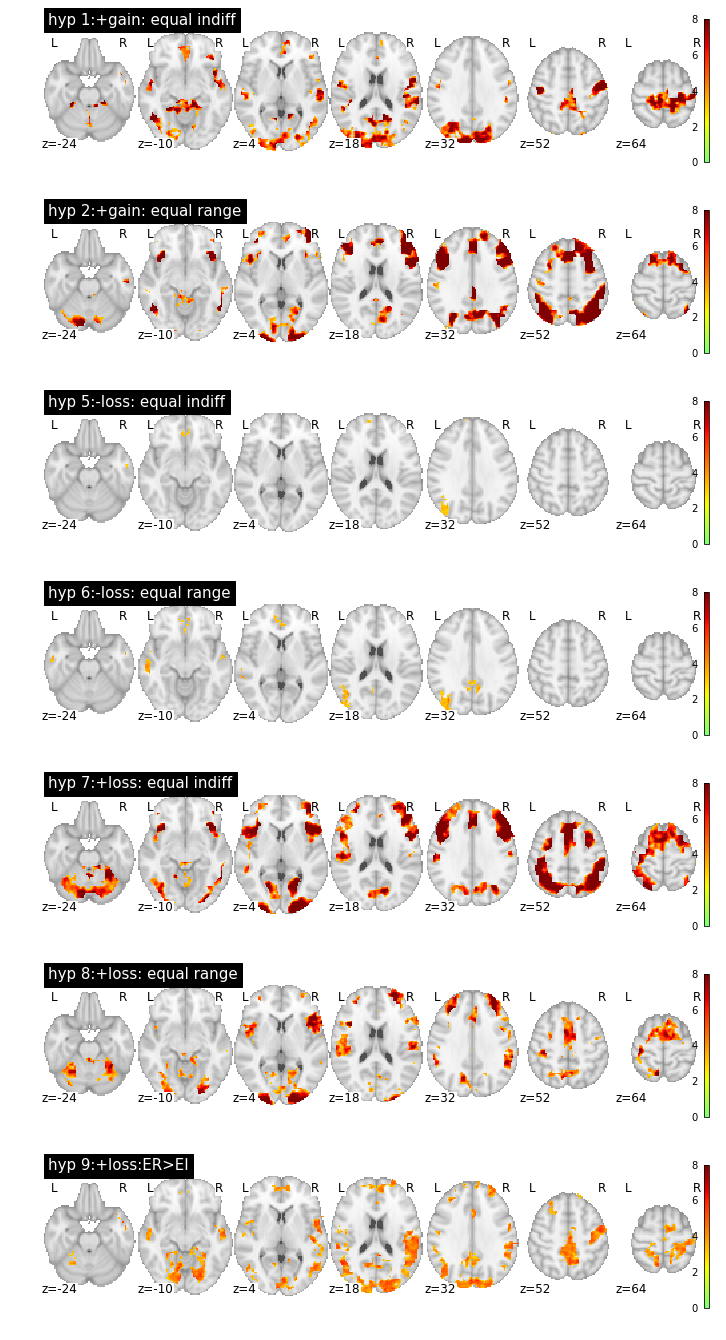

In [28]:


fig, ax = plt.subplots(7,1,figsize=(12,24))
thresh=0.95
hypnums=[1,2,5,6,7,8,9]
cut_coords = [-24,-10,4,18,32,52,64]
hypotheses= {1:'+gain: equal indiff',
            2:'+gain: equal range',
            3:'+gain: equal indiff',
            4:'+gain: equal range',
            5:'-loss: equal indiff',
            6:'-loss: equal range',
            7:'+loss: equal indiff',
            8:'+loss: equal range',
            9:'+loss:ER>EI'}

for i,hyp in enumerate(hypnums):
    pmap = os.path.join(output_dir,'unthresh_randomise/hypo%d_clustere_corrp_tstat1.nii.gz'%hyp)
    tmap =  os.path.join(output_dir,'unthresh_randomise/hypo%d_tstat1.nii.gz'%hyp)
    pimg = nibabel.load(pmap)
    timg = nibabel.load(tmap)
    threshdata = (pimg.get_data()>thresh)*timg.get_data()
    threshimg = nibabel.Nifti1Image(threshdata,affine=timg.affine)
    nilearn.plotting.plot_stat_map(threshimg, threshold=0.1, display_mode="z", 
                colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=8,cmap='jet',
                                  cut_coords = cut_coords,axes = ax[i])

plt.savefig(os.path.join(figure_dir,'consensus_map.pdf'))
